In [1]:
import numpy as np
import re

from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
def sequence_to_text(list_of_indices):
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

In [3]:
with open('train_data_true', 'r', encoding='utf-8') as f:
    texts_true = f.readlines()
    texts_true[0] = texts_true[0].replace('\ufeff', '') #убираем первый невидимый символ

with open('train_data_false', 'r', encoding='utf-8') as f:
    texts_false = f.readlines()
    texts_false[0] = texts_false[0].replace('\ufeff', '') #убираем первый невидимый символ

In [4]:
texts = texts_true + texts_false
count_true = len(texts_true)
count_false = len(texts_false)
total_lines = count_true + count_false
print(count_true, count_false, total_lines)

84 88 172


In [5]:
maxWordsCount = 1000
tokenizer = Tokenizer(num_words=maxWordsCount, 
                      filters='!–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r«»', 
                      lower=True, 
                      split=' ', 
                      char_level=False)

tokenizer.fit_on_texts(texts)

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print(reverse_word_map)

{1: 'не', 2: 'и', 3: 'в', 4: 'вы', 5: 'на', 6: 'я', 7: 'а', 8: 'только', 9: 'что', 10: 'все', 11: 'это', 12: 'если', 13: 'жизнь', 14: 'просто', 15: 'с', 16: 'чем', 17: 'никогда', 18: 'чтобы', 19: 'к', 20: 'у', 21: 'больше', 22: 'себя', 23: 'то', 24: 'всегда', 25: 'вас', 26: 'меня', 27: 'за', 28: 'вам', 29: 'когда', 30: 'от', 31: 'мне', 32: 'быть', 33: 'жизни', 34: 'есть', 35: 'но', 36: 'сделать', 37: 'без', 38: 'позитивным', 39: 'никому', 40: 'как', 41: 'ты', 42: 'тем', 43: 'для', 44: 'день', 45: 'позитивное', 46: 'своих', 47: 'мы', 48: 'много', 49: 'тебя', 50: 'никто', 51: 'такой', 52: 'деньги', 53: 'денег', 54: 'позитивно', 55: 'свою', 56: 'которые', 57: 'значит', 58: 'так', 59: 'них', 60: 'мечты', 61: 'нужно', 62: 'того', 63: 'ничего', 64: 'лучше', 65: 'надо', 66: 'верьте', 67: 'понедельник', 68: 'живи', 69: 'позволяйте', 70: 'хорошее', 71: 'можете', 72: 'ваши', 73: 'других', 74: 'делай', 75: 'тебе', 76: 'можешь', 77: 'успеха', 78: 'ваша', 79: 'стоит', 80: 'себе', 81: 'своей', 82: '

In [6]:
dist = list(tokenizer.word_counts.items())
print(dist[:10])
print(texts[0][:100])

[('думайте', 1), ('позитивно', 4), ('и', 50), ('верьте', 3), ('в', 38), ('свою', 4), ('способность', 1), ('достигать', 1), ('отличных', 1), ('результатов', 1)]
Думайте позитивно и верьте в свою способность достигать отличных результатов. 



In [7]:
max_text_len = 10
data = tokenizer.texts_to_sequences(texts)
data_pad = pad_sequences(data, maxlen = max_text_len)
print(data_pad)

#print( list(tokenizer.word_index.items()) )

[[197  54   2 ... 199 200 201]
 [  0   4 202 ... 205   3  67]
 [206   3  67 ...   4 208 209]
 ...
 [  0  20  62 ...  53 850 851]
 [  0   0  43 ...  33   1 853]
 [  0   0   0 ...  70  65 194]]


In [8]:
X = data_pad
Y = np.array([[1, 0]]*count_true + [[0, 1]]*count_false)
print(X.shape, Y.shape)

indeces = np.random.choice(X.shape[0], size=X.shape[0], replace=False)
X = X[indeces]
Y = Y[indeces]

print(data_pad.shape)
print("indeces: ", indeces)

(172, 10) (172, 2)
(172, 10)
indeces:  [ 71 171  61  64  92  15  72 166  39 169  82 165  50 151  14 109 124  93
  70 156  77  58  79  17 139 117  46 127 122   6 133  21  24 148  18 110
 159  81  59 152  16   0  87  80  35  44  96  84  98  57 129  55 158 105
  85 164 154  20   5 146   9  11 137 163 134   7  10  66  86  52   3 161
  56   8  62 131  33 125 115  51  37 119  30  32 140  90 100  67 107 126
 111  94  83  26 113  65  41 118 132  91 114  49 157  31 106  25  53  73
 120 116  45  88 102 112 142 145  13 155 103  38  19  42 153  75  27  63
 149 121   1  29 104 150 167  99 128   4  12  76 143 144 108  22 123 138
  23 170  36 101 135  28  89  47  48 141  43  97  78  74  95   2 168 136
 147  60 160  34  54  68  69  40 130 162]


In [9]:
print(X.shape)

(172, 10)


In [10]:
model = Sequential()
model.add(Embedding(maxWordsCount, 128, input_length = max_text_len))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(2, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 128)           128000    
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 309,122
Trainable params: 309,122
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.0001))

In [12]:
history = model.fit(X, Y, batch_size=32, epochs=50, validation_split=0.15)

Epoch 1/50
5/5 [==============================] - 1s 147ms/step - loss: 0.6949 - accuracy: 0.3425 - val_loss: 0.6932 - val_accuracy: 0.5769
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5616 - val_loss: 0.6906 - val_accuracy: 0.6154
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 0.6893 - accuracy: 0.5822 - val_loss: 0.6880 - val_accuracy: 0.5385
Epoch 4/50
5/5 [==============================] - 0s 6ms/step - loss: 0.6862 - accuracy: 0.5822 - val_loss: 0.6850 - val_accuracy: 0.5385
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 0.6829 - accuracy: 0.5890 - val_loss: 0.6816 - val_accuracy: 0.5385
Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 0.6788 - accuracy: 0.6027 - val_loss: 0.6775 - val_accuracy: 0.5385
Epoch 7/50
5/5 [==============================] - 0s 8ms/step - loss: 0.6749 - accuracy: 0.6096 - val_loss: 0.6726 - val_accuracy: 0.5385
Epoch 8/50
5/5 [================

In [13]:
#Sequential.fit?

In [14]:
#reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [15]:
t = "негативы".lower()
data = tokenizer.texts_to_sequences([t])
print(data)
data_pad = pad_sequences(data, maxlen=max_text_len)
print( sequence_to_text(data[0]) )

res = model.predict(data_pad)
print(res, np.argmax(res), sep='\n')

[[360]]
['негативы']
[[0.26163244 0.7383675 ]]
1


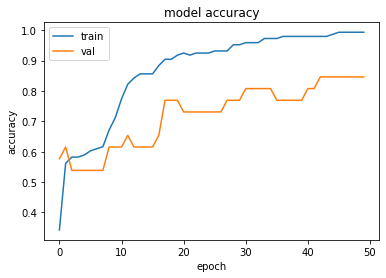

In [16]:
# Вывод графика изменения ошибки
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

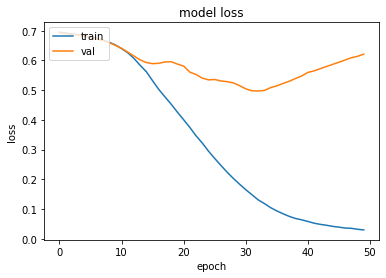

In [17]:
# Вывод графика изменения ошибки
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()